In [1]:
import os
import pandas as pd
import numpy as np
from dotenv import load_dotenv
from PIL import Image
import matplotlib.pyplot as plt
from src.wards_data import WardDataset

In [2]:
load_dotenv()

STRATZ_TOKEN = os.getenv('STRATZ_TOKEN')
if not STRATZ_TOKEN:
    raise FileNotFoundError("Not found STRATZ_TOKEN on .env")

ward_dataset = WardDataset(STRATZ_TOKEN)

In [3]:
df_data = ward_dataset.get_by_time_merged_dataset()
df_data

time               id       match  positionX  positionY  wardType  \
0         -2   7811671022_450  7811671022         38         36  OBSERVER   
1         -1   7811671022_450  7811671022         38         36  OBSERVER   
2          0   7811671022_450  7811671022         38         36  OBSERVER   
3          1   7811671022_450  7811671022         38         36  OBSERVER   
4          2   7811671022_450  7811671022         38         36  OBSERVER   
...      ...              ...         ...        ...        ...       ...   
101301    20  7786842368_2313  7786842368         42         17    SENTRY   
101302    19  7786842368_1040  7786842368         22         33  OBSERVER   
101303    20  7786842368_1040  7786842368         22         33  OBSERVER   
101304    20  7786842368_2405  7786842368         43         23  OBSERVER   
101305    20   7786842368_842  7786842368         16         22    SENTRY   

        isRadiant playerDestroyed  didRadiantWin     radiantTeam  \
0            True            None           True  Tundra Esports   
1            True            None           True  Tundra Esports   
2            True            None           True  Tundra Esports   
3            True            None           True  Tundra Esports   
4            True            None           True  Tundra Esports   
...           ...             ...            ...             ...   
101301       True            None          False  The Chapulines   
101302      False            None          False  The Chapulines   
101303      False            None          False  The Chapulines   
101304       True            None          False  The Chapulines   
101305       True            None          False  The Chapulines   

                 direTeam  league  region  didWardWin  
0               PSG.Quest   16842  EUROPE        True  
1               PSG.Quest   16842  EUROPE        True  
2               PSG.Quest   16842  EUROPE        True  
3               PSG.Quest   16842  EUROPE        True  
4               PSG.Quest   16842  EUROPE        True  
...                   ...     ...     ...         ...  
101301  Shopify Rebellion   16844      NA       False  
101302  Shopify Rebellion   16844      NA        True  
101303  Shopify Rebellion   16844      NA        True  
101304  Shopify Rebellion   16844      NA       False  
101305  Shopify Rebellion   16844      NA       False  

[101306 rows x 14 columns]

In [4]:
BG_MAP_SIZE = np.array((5000, 5000))

(76, 78, 3)
[  0.   1.   2.   3.   4.   5.   6.   7.   8.   9.  10.  11.  12.  13.
  14.  15.  16.  17.  18.  19.  20.  21.  22.  23.  24.  25.  26.  28.
  29.  30.  31.  32.  38.  39.  41.  43.  45.  47.  52.  55.  57.  58.
  66.  67.  70.  79. 100.]


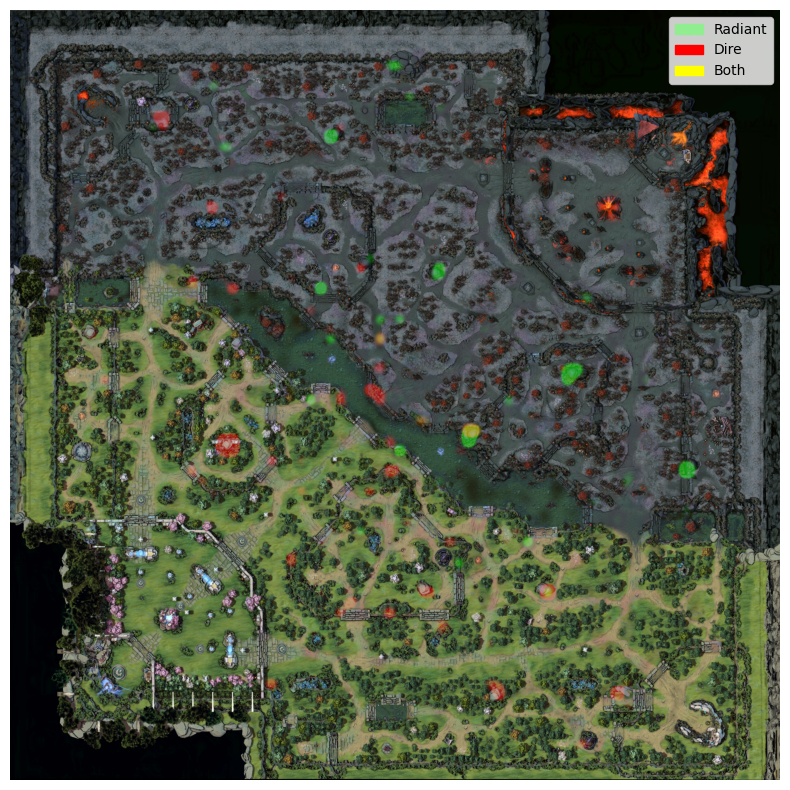

In [5]:

import matplotlib.patches as mpatches
map_size = (df_data['positionY'].max()+5, df_data['positionX'].max()+5)
def wards_hotmap(df: pd.DataFrame):
    
    # load bg_map
    bg_map = np.array(Image.open('assets\Game_map_7.33.webp').resize(BG_MAP_SIZE))

    positionX = df['positionX']
    positionY = df['positionY']
    isRadiant = df['isRadiant']
    didWardWin = df['didWardWin']
    
    # get blank arr map
    
    map = np.zeros((map_size[0], map_size[1], 3))
    print(map.shape)

    for px, py, is_radiant, did_ward_win in zip(positionX, positionY, isRadiant, didWardWin):
        color_channels = (False,True,False) if is_radiant else (True,False,False)
        # print(map[py, px, color_channels])
        map[py, px, color_channels] += 1 if did_ward_win else -1
    map = np.clip(map * 1., a_min=0, a_max=float("+inf"))
    print(np.unique(map))
    map = (map * 255) // map.max()
    map = np.flip(map, axis=0)
    map_to_pil = map.astype(np.uint8)
    map = np.array(Image.fromarray(map_to_pil).resize(BG_MAP_SIZE, resample=Image.Resampling.LANCZOS))
    map = np.clip(map * 3., a_min=0, a_max=195)
    # map[:,:,2] = 0 
    
    map_alpha = map / 255

    merged_map = map * map_alpha + bg_map * (1 - map_alpha)
    merged_map = np.array(merged_map, dtype=np.uint8)

    # merged_map = bg_map.copy()
    # merged_map[map_mask] = map[map_mask]
    # print(np.unique(merged_map))
    return merged_map
mask = df_data['wardType'] == "OBSERVER"
plt.figure(figsize=(10,10), dpi=100)
plt.axis('off')

# Create custom legend patches
legend_patches = [
    mpatches.Patch(color='#90ee90', label='Radiant'),
    mpatches.Patch(color='red', label='Dire'),
    mpatches.Patch(color='yellow', label='Both')
]

# Add legend to the plot
plt.legend(handles=legend_patches, loc='upper right')

plt.imshow(wards_hotmap(df_data[mask]))

(76, 78, 3)
[0. 1.]


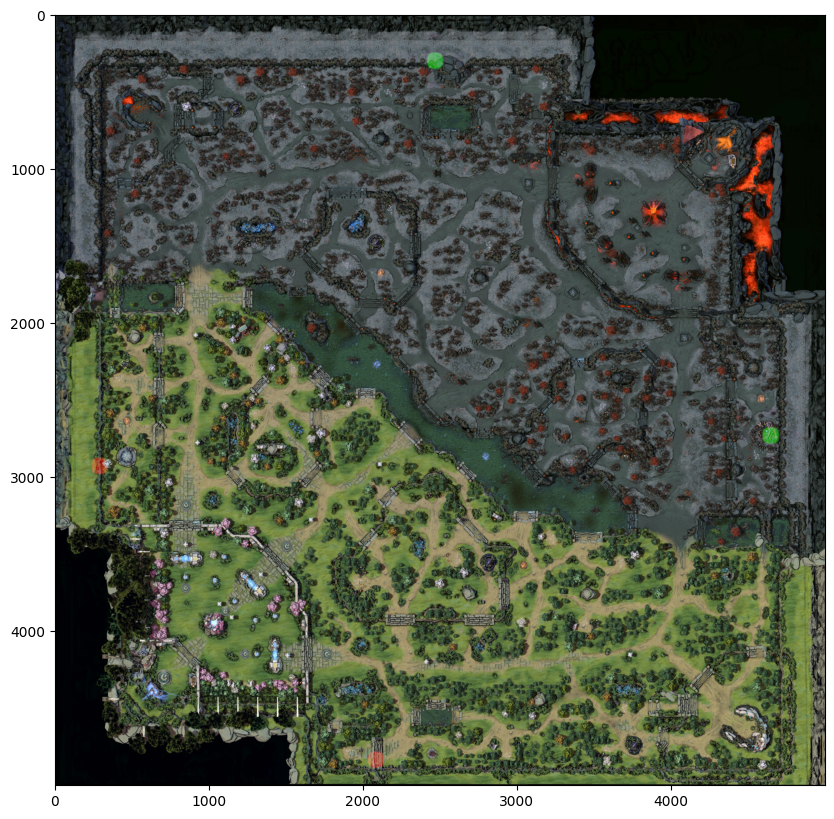

In [6]:
df_observer = df_data[mask].reset_index()


sample = pd.concat([
    df_observer.iloc[df_observer['positionX'].idxmax()].to_frame().T,
    df_observer.iloc[df_observer['positionX'].idxmin()].to_frame().T,
    df_observer.iloc[df_observer['positionY'].idxmax()].to_frame().T,
    df_observer.iloc[df_observer['positionY'].idxmin()].to_frame().T,
])

plt.figure(figsize=(10,10))
plt.imshow(wards_hotmap(sample))

In [7]:
df_observer

index  time               id       match  positionX  positionY  \
0           0    -2   7811671022_450  7811671022         38         36   
1           1    -1   7811671022_450  7811671022         38         36   
2           2     0   7811671022_450  7811671022         38         36   
3           3     1   7811671022_450  7811671022         38         36   
4           4     2   7811671022_450  7811671022         38         36   
...       ...   ...              ...         ...        ...        ...   
35509  101286    19  7786842368_2094  7786842368         42         12   
35510  101287    20  7786842368_2094  7786842368         42         12   
35511  101302    19  7786842368_1040  7786842368         22         33   
35512  101303    20  7786842368_1040  7786842368         22         33   
35513  101304    20  7786842368_2405  7786842368         43         23   

       wardType  isRadiant playerDestroyed  didRadiantWin     radiantTeam  \
0      OBSERVER       True            None           True  Tundra Esports   
1      OBSERVER       True            None           True  Tundra Esports   
2      OBSERVER       True            None           True  Tundra Esports   
3      OBSERVER       True            None           True  Tundra Esports   
4      OBSERVER       True            None           True  Tundra Esports   
...         ...        ...             ...            ...             ...   
35509  OBSERVER      False            None          False  The Chapulines   
35510  OBSERVER      False            None          False  The Chapulines   
35511  OBSERVER      False            None          False  The Chapulines   
35512  OBSERVER      False            None          False  The Chapulines   
35513  OBSERVER       True            None          False  The Chapulines   

                direTeam  league  region  didWardWin  
0              PSG.Quest   16842  EUROPE        True  
1              PSG.Quest   16842  EUROPE        True  
2              PSG.Quest   16842  EUROPE        True  
3              PSG.Quest   16842  EUROPE        True  
4              PSG.Quest   16842  EUROPE        True  
...                  ...     ...     ...         ...  
35509  Shopify Rebellion   16844      NA        True  
35510  Shopify Rebellion   16844      NA        True  
35511  Shopify Rebellion   16844      NA        True  
35512  Shopify Rebellion   16844      NA        True  
35513  Shopify Rebellion   16844      NA       False  

[35514 rows x 15 columns]

In [8]:
df_observer['score'] = df_observer['didWardWin'].map(lambda x: 1 if x == True else -1)
df_scores = df_observer.groupby(['positionX', 'positionY', 'isRadiant'])['score'].sum().to_frame().reset_index()
df_scores['didWardWin'] = True
df_scores

positionX  positionY  isRadiant  score  didWardWin
0             4         31      False      1        True
1             5         53       True     -6        True
2             6         29       True     -6        True
3             6         30      False      6        True
4             6         33      False     -6        True
...         ...        ...        ...    ...         ...
2008         71         42       True      6        True
2009         71         43      False      6        True
2010         72         34       True      2        True
2011         72         35       True      2        True
2012         72         37       True      6        True

[2013 rows x 5 columns]

In [9]:
df_scores.iloc[df_scores['score'].idxmax()]

positionX        54
positionY        18
isRadiant     False
score           100
didWardWin     True
Name: 1652, dtype: object

(76, 78, 3)
[0. 1.]


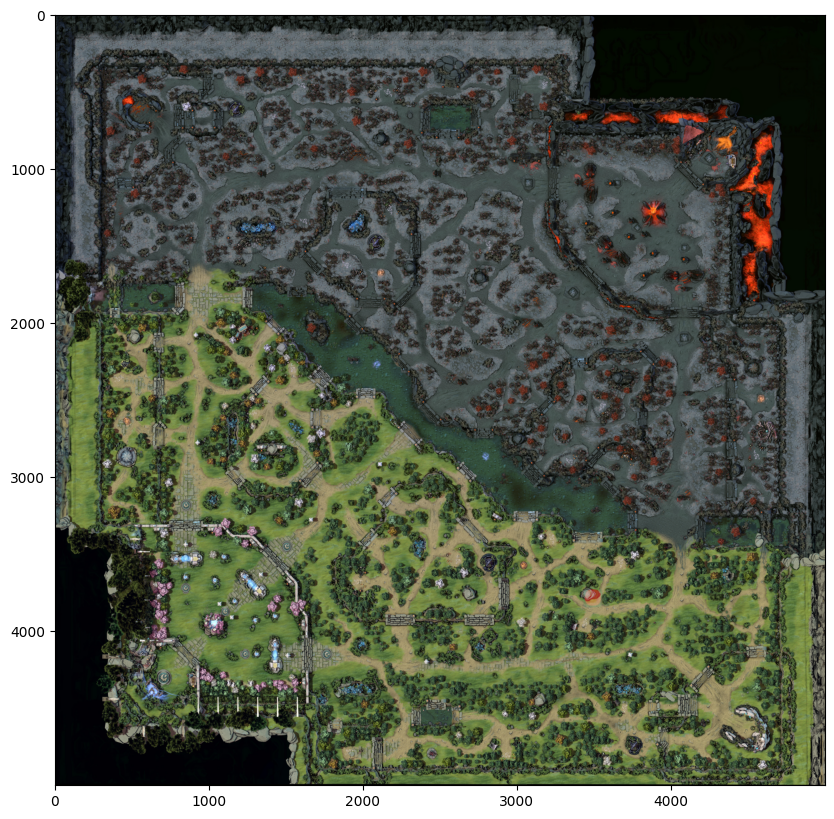

In [10]:
plt.figure(figsize=(10,10), dpi=100)
plt.imshow(wards_hotmap(df_scores.iloc[df_scores['score'].idxmax()].to_frame().T))
plt.show()

## tensor

In [11]:
import torch
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

In [12]:
torch.tensor

<function torch._VariableFunctionsClass.tensor>